<a href="https://colab.research.google.com/github/Noy-Bo/Cancer-Cell-Segmentation/blob/master/Cancer_Cell_Segmentation_MicroNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

mounting drive, setting root path to PanNuke dataset, setting device to cuda, checking out GPU


In [ ]:
ROOT_PATH = ""

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
root_path = '/content/gdrive/MyDrive/Colab/Cell Segmentation/' 
os.chdir(root_path)
!ls

'Cancer Cell Segmentation MicroNet.ipynb'
 Dataset
 my_checkpoint_ce+dice_final2.pth.tar
 my_checkpoint_ce_final2.pth.tar
 my_checkpoint_dice_final2.pth.tar
 my_checkpoint_focal+dice_final2.pth.tar


In [ ]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [ ]:
!nvidia-smi

Thu Sep  2 12:47:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   6800MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Dataset**
loading files, creating dataloaders, etc..



In [ ]:
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
import numpy as np
import pickle
import random
from torchvision.transforms import transforms


class PanNukeDataset(Dataset):
    def  __init__(self, image_dir, masks_dir=None, cancer_types_dir=None, transform=None, augment=False):
        #self.image_dir = image_dir
        #self.masks_dir = masks_dir
        #self.cancer_types_dir = cancer_types_dir
        self.transform = transform

        # Data is pickled into dictionaries ({'images': imgs, 'cancer_types': cancer_types, 'masks':masks}), let's open it up:
        with open(image_dir, mode='rb') as f:  # The with just manages closing of files and etc once finished.
            data_dict = pickle.load(f)  # load the original pickled dataset

        self.images = data_dict['images']
        self.cancer_types = data_dict['cancer_types']
        self.masks = data_dict['masks']

    def __len__(self):
        return self.images.shape[0]

    # returns images,masks   FOR NOW IT DOESN'T RETURN cancer_types!!!
    def __getitem__(self, index):
        image = self.images[index, ...].astype(dtype=np.float32)
        mask = self.masks[index, ...].astype(dtype=np.float32)
        mask[mask > 0] = 1.0

        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        
        # AUGMENTATION
        if self.transform is True:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

            # ROTATION
            if random.random() >= 0.5:
                times = 1
                rnd = random.random()
                if  0.66 > rnd > 0.33:
                    times = 2
                elif rnd > 0.66:
                    times = 3
                image = torch.rot90(image,times,(1,2))
                mask = torch.rot90(mask,times,(1,2))

            # FLIP
            if random.random() >= 0.5:
                trans = transforms.RandomVerticalFlip(1)
                if random.random() >= 0.5:
                    trans = transforms.RandomHorizontalFlip(1)
                image = trans(image)
                mask = trans(mask)
            
            # Gaussian Blur (with parameters according to paper)
            # if random.random() >= 0.5:
            #   trans = transforms.GaussianBlur(12,sigma=(0.2,2.0))
            #   image = trans(image)
            #   #mask = trans(mask) 

            image = image.numpy()
            mask = mask.numpy()

        # Normalize 
        image = image / 255
        image = transforms.Normalize(mean=[0.74636905, 0.58091097, 0.7092674 ], std=[0.18765187, 0.22254046, 0.17476417])(image)

        if torch.is_tensor(image):
            return image, mask
        else:
            return torch.from_numpy(image), torch.from_numpy(mask)




# Creating data loaders:
def load_dataset(batch_size, shuffle_flag, num_workers=None, data_dir=None, transforms=None, augment=None):
  dataset = PanNukeDataset(data_dir, augment=augment)
  if num_workers is not None : # Colab case...
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_flag, num_workers=num_workers)
  else :
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_flag)

  return data_loader


# **Model**
Micro-Net Model configuration (according to the paper, adjusted to 256x256 images)

In [ ]:

import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as TNF
import torch.nn.modules
from torch import optim
import time
from torch.utils.data import DataLoader
from torchsummary import summary
import tqdm

# Small useful components:
# this class is to be able to use TNF.interpole within nn.Sequential()
class Interpolate(nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = TNF.interpolate
        self.size = size
        self.mode = mode

    def forward(self, x):
        return self.interp(x, size=self.size, mode=self.mode, align_corners=False)

# Create the Micro-Net components:
class Group1_B1(nn.Module):
    def __init__(self, in_channels=3):
        super(Group1_B1, self).__init__()

        self.sub_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=5, stride=1, padding=0, bias=False), # kernel=5 since we start with 256 imgs, where in paper it's 252
            nn.BatchNorm2d(64), # out_channels=64
            nn.Tanh(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),  # REMOVE?
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        ) #124,124,64

        self.sub_block2 = nn.Sequential(
            Interpolate(size=(128,128),mode='bicubic'),
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),  # out_channels=64
            nn.Tanh(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.Tanh(),
        )

    def forward(self, orig_input):
        sub_block1 = self.sub_block1(orig_input) # recall it outputs: B,CH,HEIGHT,WIDTH
        sub_block2 = self.sub_block2(orig_input)
        B1 = torch.cat((sub_block1,sub_block2), dim=1) # concat alongside channels dim'
        return B1

class Group1_B2(nn.Module):
    def __init__(self, in_channels=128):
        super(Group1_B2, self).__init__()
        self.sub_block1 = nn.Sequential(  # gets 124^2, ch=128,   outputs: 60^2, ch=128
            nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, stride=1, padding=0, bias=True), # bias=True since no BN is applied.
            nn.Tanh(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, bias=True),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.sub_block2 = nn.Sequential( # gets 256^2, ch=3  outputs: 60^2, ch=128
            Interpolate(size=(64, 64), mode='bicubic'),
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.Tanh(),
        )

    def forward(self, B1_input, orig_input):
        sub_block1 = self.sub_block1(B1_input)
        sub_block2 = self.sub_block2(orig_input)
        B2 = torch.cat((sub_block1, sub_block2), dim=1)  # concat alongside channels dim'
        return B2

class Group1_B3(nn.Module):
    def __init__(self, in_channels=256):
        super(Group1_B3, self).__init__()
        self.sub_block1 = nn.Sequential(  # gets 60^2, ch=256,   outputs: 28^2, ch=256
            nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True), # bias=True since no BN is applied.
            nn.Tanh(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.sub_block2 = nn.Sequential( # gets 256^2, ch=3  outputs: 28^2, ch=256
            Interpolate(size=(32, 32), mode='bicubic'),
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.Tanh(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.Tanh(),
        )

    def forward(self, B2_input, orig_input):
        sub_block1 = self.sub_block1(B2_input)
        sub_block2 = self.sub_block2(orig_input)
        B3 = torch.cat((sub_block1, sub_block2), dim=1)  # concat alongside channels dim'
        return B3

class Group1_B4(nn.Module):
    def __init__(self, in_channels=512):
        super(Group1_B4, self).__init__()
        self.sub_block1 = nn.Sequential(  # gets 28^2, ch=512,   outputs: 12^2, ch=512
            nn.Conv2d(in_channels=in_channels, out_channels=512, kernel_size=3, stride=1, padding=0, bias=True), # bias=True since no BN is applied.
            nn.Tanh(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0, bias=True),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.sub_block2 = nn.Sequential( # gets 256^2, ch=3  outputs: 12^2, ch=512
            Interpolate(size=(16, 16), mode='bicubic'),
            nn.Conv2d(in_channels=3, out_channels=512, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.Tanh(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.Tanh(),
        )

    def forward(self, B3_input, orig_input):
        sub_block1 = self.sub_block1(B3_input)
        sub_block2 = self.sub_block2(orig_input)
        B4 = torch.cat((sub_block1, sub_block2), dim=1)  # concat alongside channels dim'
        return B4

class Group2_B5(nn.Module):
    def __init__(self, in_channels=1024):
        super(Group2_B5, self).__init__()
        self.sub_block = nn.Sequential(  # gets 12^2, ch=1024,   outputs: 8^2, ch=2048
            nn.Conv2d(in_channels=in_channels, out_channels=2048, kernel_size=3, stride=1, padding=0, bias=False), 
            nn.BatchNorm2d(2048),
            nn.Tanh(),
            nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(2048),
            nn.Dropout2d(p=0.5),
            nn.Tanh(),
        )

    def forward(self, B4_input):
        B5 = self.sub_block(B4_input)
        return B5

class Group3_Bi(nn.Module):
    def __init__(self, in_channels_prev_b, in_channels_g1):
        super(Group3_Bi, self).__init__()
        # ------------------- UNSURE HERE REGARDING THE 1ST SUBBLOCK, WE DECONV UP TO 16 THEN CONV TWICE TO 8 THEN AGAIN DECONV UP TO 16?????
        # First-part of the block:
        self.sub_block1 = nn.Sequential(  # gets size^2, #channels, outputs (size*2)^2, #channels/2
            nn.ConvTranspose2d(in_channels=in_channels_prev_b, out_channels=round(in_channels_prev_b / 2),kernel_size=2, stride=2, padding=0), # double x=h,w to 2x X 2x
            nn.Conv2d(in_channels=round(in_channels_prev_b / 2), out_channels=round(in_channels_prev_b / 2), kernel_size=3, stride=1, padding=0, bias=False), # turn to 2x-2 X 2x-2
            nn.BatchNorm2d(round(in_channels_prev_b/2)),
            nn.Tanh(),
            nn.Conv2d(in_channels=round(in_channels_prev_b / 2), out_channels=round(in_channels_prev_b / 2), kernel_size=3, stride=1, padding=0, bias=False),  # turn to 2x -4 X 2x-4
            nn.BatchNorm2d(round(in_channels_prev_b/2)),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=round(in_channels_prev_b / 2), out_channels=round(in_channels_prev_b / 2), kernel_size=5, stride=1, padding=0),  # turn back to 2x X 2x,
        )

        # Mid-part of the block:
        self.sub_block2 = nn.ConvTranspose2d(in_channels=in_channels_g1, out_channels=in_channels_g1, kernel_size=5, stride=1, padding=0) # it upsamples by 4 only

        # Third-part of the block:
        self.sub_block3 = nn.Sequential(
            nn.Conv2d(in_channels=round(in_channels_g1*2), out_channels=in_channels_g1, kernel_size=3, stride=1, padding=1, bias=False), # same conv
            nn.BatchNorm2d(in_channels_g1),
            nn.Tanh()
        )

    def forward(self, g1_input, prev_b_input):
        sub_block1 = self.sub_block1(prev_b_input)
        sub_block2 = self.sub_block2(g1_input)
        sub_block3 = torch.cat((sub_block1, sub_block2), dim=1)  # concat alongside channels dim'
        Bi = self.sub_block3(sub_block3)
        return Bi

class Group4_Pa1(nn.Module):
    def __init__(self):
        super(Group4_Pa1, self).__init__()
        self.sub_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2), #upsample by 2x
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),  #UNLIKE THE PAPER, we'll use same convs, in order to get final-output= 256x256 as out data imgs
            nn.BatchNorm2d(64),
            nn.Tanh(),
        )

        self.sub_block2 = nn.Sequential(
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=64, out_channels=6, kernel_size=1, stride=1, padding=0), #unlike paper ^^
            #nn.Tanh(inplace=True), # Since it's output layer ^^..
        )

    def forward(self, b9_input):
        x1 = self.sub_block1(b9_input) # this also goes onwards to Group5
        pa1 = self.sub_block2(x1)
        return pa1, x1

class Group4_Pa2(nn.Module):
    def __init__(self):
        super(Group4_Pa2, self).__init__()
        self.sub_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=4), #upsample by 4x
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),  #UNLIKE THE PAPER, we'll use same convs, in order to get final-output= 256x256 as out data imgs
            nn.BatchNorm2d(128),
            nn.Tanh(),
        )

        self.sub_block2 = nn.Sequential(
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=128, out_channels=6, kernel_size=1, stride=1, padding=0), #unlike paper ^^
            #nn.Tanh(inplace=True), # Since it's output layer ^^..
        )

    def forward(self, b8_input):
        x2 = self.sub_block1(b8_input) # this also goes onwards to Group5
        pa2 = self.sub_block2(x2)
        return pa2, x2

class Group4_Pa3(nn.Module):
    def __init__(self):
        super(Group4_Pa3, self).__init__()
        self.sub_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=8, stride=8), #upsample by 8x
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),  #UNLIKE THE PAPER, we'll use same convs, in order to get final-output= 256x256 as out data imgs
            nn.BatchNorm2d(256),
            nn.Tanh(),
        )

        self.sub_block2 = nn.Sequential(
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=256, out_channels=6, kernel_size=1, stride=1, padding=0), #unlike paper ^^
            #nn.Tanh(inplace=True), # Since it's output layer ^^..
        )

    def forward(self, b7_input):
        x3 = self.sub_block1(b7_input) # this also goes onwards to Group5
        pa3 = self.sub_block2(x3)
        return pa3, x3

class Group5(nn.Module):
    def __init__(self):
        super(Group5, self).__init__()
        self.sub_block = nn.Sequential( #unlike the paper, the input for this stage is 256x256, 448(after concat)
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=448, out_channels=6, kernel_size=1, stride=1, padding=0), #unlike paper ^^
        )

    def forward(self, x1, x2, x3):
        x = torch.cat((x1, x2, x3), dim=1) # concat x1,x2,x3 alongside channels dim'
        p0 = self.sub_block(x)
        return p0

class MicroNet(nn.Module):
    def __init__(self):
        super(MicroNet, self).__init__()
        self.group1_b1 = Group1_B1()
        self.group1_b2 = Group1_B2()
        self.group1_b3 = Group1_B3()
        self.group1_b4 = Group1_B4()
        self.group2 = Group2_B5()
        self.group3_b6 = Group3_Bi(in_channels_prev_b=2048, in_channels_g1=1024)
        self.group3_b7 = Group3_Bi(in_channels_prev_b=1024, in_channels_g1=512)
        self.group3_b8 = Group3_Bi(in_channels_prev_b=512, in_channels_g1=256)
        self.group3_b9 = Group3_Bi(in_channels_prev_b=256, in_channels_g1=128)
        self.group4_pa1 = Group4_Pa1()
        self.group4_pa2 = Group4_Pa2()
        self.group4_pa3 = Group4_Pa3()
        self.group5 = Group5()

    def forward(self, x):
        # Propagate through G1:
        b1 = self.group1_b1(x)
        b2 = self.group1_b2(b1, x)
        b3 = self.group1_b3(b2, x)
        b4 = self.group1_b4(b3, x)

        # Propagate through G2:
        b5 = self.group2(b4)

        # Propagate through G3:
        b6 = self.group3_b6(b4, b5)
        b7 = self.group3_b7(b3, b6)
        b8 = self.group3_b8(b2, b7)
        b9 = self.group3_b9(b1, b8)

        # Propagate through G4:
        pa1, x1 = self.group4_pa1(b9)
        pa2, x2 = self.group4_pa2(b8)
        pa3, x3 = self.group4_pa3(b7)

        # Propagate through G5:
        p0 = self.group5(x1, x2, x3)

        return p0, pa1, pa2, pa3  # recall that p0 = main output, pa1,pa2,pa3 = auxiliary outputs


# **Train, Evaluation & Other model Utilities**
loss functions configurations, train epoch function ..


In [ ]:
import matplotlib.pyplot as plt
from typing import Optional, Sequence
from torch import Tensor
from torch.nn import functional as F



# If loss_type = "dice+wce/ce" then loss_func will hold a list of the loss functions used
def train_micronet(model, loader, opt, loss_func, scheduler, epoch, loss_type):
    epoch_loss = 0

    # Train the model (turn training-mode on if on trianing..)
    model.train()


    with tqdm.tqdm(total=len(loader), file=sys.stdout) as pbar:
        for (images, masks) in loader:
            images = images.to(device)
            masks = masks.to(device)

            # reinitialize gradients..
            opt.zero_grad()

            # Calculation of loss (according to paper):
            p0, pa1, pa2, pa3 = model(images) # Pi.shape, 256x256x5
            masks = torch.argmax(masks, dim=1) # B,CH=1,H,W
            if loss_type == "ce" or loss_type == "dice" or loss_type == "wce" or loss_type == "focal":  # Perform CE/DICE/WCE loss
                l0 = loss_func(p0, masks)
                l1 = loss_func(pa1, masks)
                l2 = loss_func(pa2, masks)
                l3 = loss_func(pa3, masks)

            if loss_type == "ce+dice" or loss_type == "wce+dice" or loss_type == "focal+dice":  # Perform CE+DICE loss (or WCE+DICE)
                loss_func1 = loss_func[0]
                loss_func2 = loss_func[1]
                l0 = loss_func1(p0, masks) + loss_func2(p0, masks)
                l1 = loss_func1(pa1, masks) + loss_func2(pa1, masks)
                l2 = loss_func1(pa2, masks) + loss_func2(pa2, masks)
                l3 = loss_func1(pa3, masks) + loss_func2(pa3, masks)

            loss = l0+(l1+l2+l3)/epoch
            loss_eval = l0+l1+l2+l3 # Since we want to see original loss and not /epoch one...


            # Backpropagation
            loss.backward()

            # Update weights according to gradients
            opt.step()

            epoch_loss += loss_eval.item()

            pbar.update()
            pbar.set_description(f'train loss={loss_eval.item():.3f}')

        pbar.set_description(f'train loss={epoch_loss / len(loader):.3f}')
    scheduler.step()

    return epoch_loss / len(loader)

# Used to calculate model's loss only
def eval_micronet_loss(model, loader, loss_func, loss_type):
    epoch_loss = 0
    model.eval()

    with tqdm.tqdm(total=len(loader), file=sys.stdout) as pbar:
        with torch.no_grad():
          for (images, masks) in loader:
              images = images.to(device)
              masks = masks.to(device)

              # Calculation of loss (according to paper):
              p0, pa1, pa2, pa3 = model(images)  # Pi.shape, 256x256x5
              masks = torch.argmax(masks, dim=1)  # B,CH=1,H,W
              if loss_type == "ce" or loss_type == "dice" or loss_type == "wce" or loss_type == "focal":  # Perform CE/DICE/WCE loss
                  l0 = loss_func(p0, masks)
                  l1 = loss_func(pa1, masks)
                  l2 = loss_func(pa2, masks)
                  l3 = loss_func(pa3, masks)

              if loss_type == "ce+dice" or loss_type == "wce+dice" or loss_type == "focal+dice":  # Perform CE+DICE loss (or WCE+DICE)
                  loss_func1 = loss_func[0]
                  loss_func2 = loss_func[1]
                  l0 = loss_func1(p0, masks) + loss_func2(p0, masks)
                  l1 = loss_func1(pa1, masks) + loss_func2(pa1, masks)
                  l2 = loss_func1(pa2, masks) + loss_func2(pa2, masks)
                  l3 = loss_func1(pa3, masks) + loss_func2(pa3, masks)

              loss_eval = l0 + l1 + l2 + l3  # Since we want to see original loss and not /epoch one...

              epoch_loss += loss_eval.item()

              pbar.update()
              pbar.set_description(f'validation loss={loss_eval.item():.3f}')

        pbar.set_description(f'validation loss={epoch_loss / len(loader):.3f}')

    return epoch_loss / len(loader)

# Can be used for multiclass...
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss ( hence the 1 - dice_score ).
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


class FocalLoss(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 2.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.nll_loss = nn.NLLLoss(weight=alpha, reduction='none', ignore_index=ignore_index)


    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)  # Will set B,C,H,W to ROWS X C
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1) # ROWS (With values between [0,C-1]

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return 0.
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def calc_PQ(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    # TP == INTERSECTION = PRED==1 GT==1
    # FP = PRED==1 GT ==0
    # FN = PRED==0 GT==1
    # TN = PRED==0, Gt==0

    outputs = outputs.int()
    labels = labels.int()
    PQ = []
    DICE = []
    IOU = []
    confusion_vector = outputs / labels
    for batch in range(outputs.shape[0]):
        for mask in range(outputs.shape[1]):
            TP = torch.sum(confusion_vector[batch,mask,...] == 1).item()
            FP = torch.sum(confusion_vector[batch,mask,...]  == float('inf')).item()
            TN = torch.sum(torch.isnan(confusion_vector[batch,mask,...])).item()
            FN = torch.sum(confusion_vector[batch,mask,...]  == 0).item()
            if FN != 0 or FP != 0 or TP != 0:
              #print("TP: {},  FP: {},  FN: {}".format(str(TP),str(FP),str(FN)) )
              IOU.append((TP ) / (TP + FP + FN))
              #PQ.append(((IOU ) / ((TP + 0.5 * FP + 0.5 * FN) )))
              DICE.append((2*TP) / (2*TP + FP + FN))
    #return (sum(PQ)/len(PQ))
    return (sum(DICE)/len(DICE)), (sum(IOU)/len(IOU))


def eval_model(model, data_loader, model_type, device):
    DICE = []
    IOU = []
    P_OVER_CLASSES = [ [] for i in range(6) ] # will hold list of lists per each class
    R_OVER_CLASSES = [ [] for i in range(6) ]
    DICE_OVER_CLASSES = [ [] for i in range(6) ]
    mean_precisions = []
    mean_recalls = []
    mean_dices = []
    model.eval()

    with tqdm.tqdm(total=len(data_loader), file=sys.stdout) as pbar:
        with torch.no_grad():

          for images, masks in data_loader:
              images = images.to(device)
              masks = masks.to(device)

              # Calculate output
              if model_type == "micronet" :
                  y_hat, _, _, _ = model(images)
              else :
                  y_hat = model(images)
              y_hat = y_hat.to(device)

              # Generate one hot vectors
              one_hot_masks = torch.nn.functional.one_hot(torch.argmax(y_hat, dim=1), num_classes=6)
              one_hot_masks = one_hot_masks.permute(0, 3, 1, 2)
              one_hot_masks = one_hot_masks.to(device)

              dice_score, iou_score = calc_PQ(outputs=one_hot_masks, labels=masks)
              percision_over_classes, recall_over_classes, dice_over_classes = percision_recall_dice_per_class(outputs=one_hot_masks, labels=masks)

              # Append batch evaluations:
              for i in range(6):
                  if percision_over_classes[i] != -1:
                      P_OVER_CLASSES[i].append( percision_over_classes[i] )
                  if recall_over_classes[i] != -1:
                      R_OVER_CLASSES[i].append( recall_over_classes[i] )
                  if dice_over_classes[i] != -1:
                      DICE_OVER_CLASSES[i].append( dice_over_classes[i] )

              DICE.append(dice_score)
              IOU.append(iou_score)
              # pbar.set_description(f' IOU ={IOU[-1]:.3f} ;'
              #                      f' DICE ={DICE[-1]:.3f} ;'
              #                      f' PERCISIONS ={P_OVER_CLASSES[0][-1]:.3f}|{P_OVER_CLASSES[1][-1]:.3f}|{P_OVER_CLASSES[2][-1]:.3f}|{P_OVER_CLASSES[3][-1]:.3f}|{P_OVER_CLASSES[4][-1]:.3f}|{P_OVER_CLASSES[5][-1]:.3f} ;'
              #                      f' RECALLS ={R_OVER_CLASSES[0][-1]:.3f}|{R_OVER_CLASSES[1][-1]:.3f}|{R_OVER_CLASSES[2][-1]:.3f}|{R_OVER_CLASSES[3][-1]:.3f}|{R_OVER_CLASSES[4][-1]:.3f}|{R_OVER_CLASSES[5][-1]:.3f} ;'
              #                      f' DICES={DICE_OVER_CLASSES[0][-1]:.3f}|{DICE_OVER_CLASSES[1][-1]:.3f}|{DICE_OVER_CLASSES[2][-1]:.3f}|{DICE_OVER_CLASSES[3][-1]:.3f}|{DICE_OVER_CLASSES[4][-1]:.3f}|{DICE_OVER_CLASSES[5][-1]:.3f} ;'
              #                      )
              pbar.update();


          # Calculate mean per epoch:
          mean_dice = torch.mean(torch.FloatTensor(DICE))
          mean_iou = torch.mean(torch.FloatTensor(IOU))
          for j in range(6):
              mean_precisions += [torch.mean(torch.FloatTensor(P_OVER_CLASSES[j]))] # P_OVER_CLASS is 5xBatchesInLoader
              mean_recalls += [torch.mean(torch.FloatTensor(R_OVER_CLASSES[j]))]
              mean_dices += [torch.mean(torch.FloatTensor(DICE_OVER_CLASSES[j]))]

          pbar.set_description(f' IOU ={mean_iou:.3f} ;'
                              f' DICE ={mean_dice:.3f} ;'
                              f' PERCISIONS ={mean_precisions[0]:.3f}|{mean_precisions[1]:.3f}|{mean_precisions[2]:.3f}|{mean_precisions[3]:.3f}|{mean_precisions[4]:.3f}|{mean_precisions[5]:.3f} ;'
                              f' RECALLS ={mean_recalls[0]:.3f}|{mean_recalls[1]:.3f}|{mean_recalls[2]:.3f}|{mean_recalls[3]:.3f}|{mean_recalls[4]:.3f}|{mean_recalls[5]:.3f} ;'
                              f' DICES={mean_dices[0]:.3f}|{mean_dices[1]:.3f}|{mean_dices[2]:.3f}|{mean_dices[3]:.3f}|{mean_dices[4]:.3f}|{mean_dices[5]:.3f} ;'
                          )
          pbar.update();

    return mean_dice, mean_iou


# REMOVE,, JUST HERE TO RECALL WHAT MASK IS WAHT CELL...
#colors = {"1neoplastic": (255, 0, 0), "2inflammatory": (0, 255, 0), "3connective": (0, 0, 255), "4dead": (255, 255, 0), "5epithelial": (255, 102, 0)}

def percision_recall_dice_per_class(outputs: torch.Tensor, labels: torch.Tensor):
    """
    :param outputs: of shape B,C=6,H,W (meaning, one-hots)
    :param labels: of shape B,C=6,H,W (meaning, one-hots)
    :return: precisions, recalls and dices over classes, meaning 3 lists containing 6 values each (background class = detection metric)
    Percision = TP / (TP + FP )
    Recall = TP / ( TP + FN )
    Dice = 2TP / ( TP + TP + FN + TP )
    """

    precision_over_classes = [ [] for i in range(6) ]
    recall_over_classes = [ [] for i in range(6) ]
    dice_over_classes = [ [] for i in range(6) ]


    labels = labels.int()
    #labels[:,5, ...] = 1-labels[:,5, ...] # taking the opposite of the mask (ie, the concat' of all cells)
    #outputs = outputs.int()
    values , inds = torch.max(outputs,dim=1)
    #outputs[:,5, ...] = values
    confusion_vector = outputs / labels
    confusion_vector[:,5] = ( torch.logical_or(outputs[:,4], torch.logical_or(outputs[:,3],torch.logical_or(outputs[:,2],torch.logical_or(outputs[:,1],outputs[:,0])))) ) / torch.logical_not(labels[:,5])
    for i in range(outputs.shape[1]): # loop over cell-types
        for j in range(outputs.shape[0]): # loop over images in batch
            TP = torch.sum(confusion_vector[j, i, ...] == 1).item()
            FP = torch.sum(confusion_vector[j, i, ...] == float('inf')).item()
            TN = torch.sum(torch.isnan(confusion_vector[j, i, ...])).item()
            FN = torch.sum(confusion_vector[j, i, ...] == 0).item()

            if FN != 0 or FP != 0 or TP != 0 : # don't include cases where cell-i isn't part of image_j's mask_i AND the model predicted 0 pixels as cell-i! (meaning, TN=0.. or one of the others != 0...)
              if TP == 0: # avoid dividing by 0...
                  precision_over_classes[i].append(0)
                  recall_over_classes[i].append(0)
                  dice_over_classes[i].append(0)
              else:
                  precision_over_classes[i].append(TP / (TP + FP))
                  recall_over_classes[i].append(TP / (TP + FN))
                  dice_over_classes[i].append(2*TP / (2*TP+FN+FP))

        precision_over_classes[i] = sum(precision_over_classes[i]) / len(precision_over_classes[i]) if len(precision_over_classes[i]) != 0 else -1
        recall_over_classes[i] = sum(recall_over_classes[i]) / len(recall_over_classes[i]) if len(recall_over_classes[i]) != 0 else -1
        dice_over_classes[i] = sum(dice_over_classes[i]) / len(dice_over_classes[i]) if len(dice_over_classes[i]) != 0 else -1

    return precision_over_classes, recall_over_classes, dice_over_classes

# **Data Utilities**
For Visualizations and etc

In [ ]:
import cv2

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(load_model_path, model):
    print("=> Loading checkpoint")
    if torch.cuda.is_available():
        checkpoint = torch.load(load_model_path)
        model.load_state_dict(checkpoint["state_dict"])
    else:
        checkpoint = torch.load(TRAINED_MODEL_PATH + "my_checkpoint.pth.tar", map_location='cpu')
        model.load_state_dict(checkpoint["state_dict"])

# VISUALIZING SAMPLES - designed for input that is the dataloader output, for raw input cancel moveaxis
def vis_sample(image, masks):
    fig, axs = plt.subplots(1,7)
    fig.set_size_inches(18.5, 3.2)
    fig.suptitle('Ground Truth', fontsize=18)
    #fig.tight_layout()
    axs[0].imshow(np.moveaxis(image.cpu().detach().numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
    masks = np.moveaxis(masks.cpu().detach().numpy().astype(np.uint8),0,-1)
    axs[1].imshow(masks[:,:,0], cmap="gray"); axs[1].set_title("Neoplastic cells")
    axs[2].imshow(masks[:,:,1], cmap="gray"); axs[2].set_title("Inflammatory")
    axs[3].imshow(masks[:,:,2], cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
    axs[4].imshow(masks[:,:,3], cmap="gray"); axs[4].set_title("Dead Cells")
    axs[5].imshow(masks[:,:,4], cmap="gray"); axs[5].set_title("Epithelial")
    axs[6].imshow(masks[:,:,5], cmap="gray"); axs[6].set_title("Background")
    plt.show()

# VISUALIZING PREDICTIONS - visualizing network output on a random sample.
def vis_predictions(data_loader, model, model_type='unet'):
    model.eval()
    image_gt_batch, masks_gt_batch = iter(data_loader).next()
    image_gt_batch = image_gt_batch.to(device)
    masks_gt_batch = masks_gt_batch.to(device)

    if model_type == "micronet" :
        pred_masks_batch, _, _, _ = model(image_gt_batch) # Grabbing only PO predictions.
    else:
        pred_masks_batch = model(image_gt_batch)

    # DE-NORM
    image_gt_batch[:,0,...] *= 0.18765187
    image_gt_batch[:,1,...] *= 0.22254046
    image_gt_batch[:,2,...] *= 0.17476417
    image_gt_batch[:,0,...] += 0.74636905
    image_gt_batch[:,1,...] += 0.58091097
    image_gt_batch[:,2,...] += 0.7092674
    image_gt_batch *= 255

    for i in range(image_gt_batch.shape[0]): # looping on batch_size
      print("\n\n")
      print("\t\t\t\t\t\t\t\t SAMPLE: {}".format(str(i)))
      image = image_gt_batch[i,...] # 3,256,256
      pred_masks = pred_masks_batch[i,...] # 6,256,256
      one_hot_masks = torch.nn.functional.one_hot(torch.argmax(pred_masks, dim=0))
      one_hot_masks = one_hot_masks.permute(2,0,1)
      one_hot_masks *= 250 # white color?
      fig, axs = plt.subplots(1,7)
      fig.set_size_inches(18.5, 3.3)
      fig.suptitle('Prediction', fontsize=18)
      #fig.tight_layout()
      axs[0].imshow(np.moveaxis(image.cpu().detach().numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
      axs[1].imshow(one_hot_masks[0,:,:].cpu().detach().numpy(), cmap="gray"); axs[1].set_title("Neoplastic cells")
      axs[2].imshow(one_hot_masks[1,:,:].cpu().detach().numpy(), cmap="gray"); axs[2].set_title("Inflammatory")
      axs[3].imshow(one_hot_masks[2,:,:].cpu().detach().numpy(), cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
      axs[4].imshow(one_hot_masks[3,:,:].cpu().detach().numpy(), cmap="gray"); axs[4].set_title("Dead Cells")
      axs[5].imshow(one_hot_masks[4,:,:].cpu().detach().numpy(), cmap="gray"); axs[5].set_title("Epithelial")
      axs[6].imshow(one_hot_masks[5,:,:].cpu().detach().numpy(), cmap="gray"); axs[6].set_title("Background")
      plt.show()

      vis_sample(image,masks_gt_batch[i,...]) # visualizing gt (ground truth)


# Visualizes a random batch from a given data-loader
def visualize_segmented_ground_truth(data_loader, model, model_type):
    # Colors according to the PanNuke-dataset paper:
    colors = {"1neoplastic":(255,0,0), "2inflammatory":(0,255,0), "3connective":(0,0,255), "4dead":(255,255,0), "5epithelial":(255,102,0)}
    model.eval()

    # Grab model predictions of a random batch:
    images_gt_batch, masks_gt_batch = iter(data_loader).next()
    images_gt_batch = images_gt_batch.to(device)
    masks_gt_batch = masks_gt_batch.to(device)

    # Grab maximum of 5 images to visualize:
    if images_gt_batch.shape[0] > 5 :
      images_gt_batch = images_gt_batch[:5, ...]
      masks_gt_batch = masks_gt_batch[:5, ...]

    with torch.no_grad():
      if model_type == "micronet":
          masks_pred_batch, _, _, _ = model(images_gt_batch)  # Grabbing only PO predictions.
      else:
          masks_pred_batch = model(images_gt_batch)

      

      # REVERT NORMALIZATION
      images_gt_batch[:, 0, ...] *= 0.18765187
      images_gt_batch[:, 1, ...] *= 0.22254046
      images_gt_batch[:, 2, ...] *= 0.17476417
      images_gt_batch[:, 0, ...] += 0.74636905
      images_gt_batch[:, 1, ...] += 0.58091097
      images_gt_batch[:, 2, ...] += 0.7092674
      images_gt_batch *= 255

      # Turn masks maps to edges maps:
      pred_masks_edges = np.zeros((masks_gt_batch.shape))
      gt_masks_edges = np.zeros((masks_gt_batch.shape))

      for i in range(images_gt_batch.shape[0]): # looping on batch_size
          # Grab the i'th prediction masks (which hold scores) and adjust it to final prediction (one hots...)
          ith_pred = masks_pred_batch[i, ...] # CH,H,W
          ith_onehot_pred_masks = torch.nn.functional.one_hot(torch.argmax(ith_pred, dim=0)) # returns HxWxCH
          ith_onehot_pred_masks = ith_onehot_pred_masks.permute(2, 0, 1) # sets dimensions so that for example, dim=2 will be now dim=0, hence will get CH,H,W

          # Grab the i'th gt masks (already onehots)
          ith_onehot_gt_masks = masks_gt_batch[i, ...]

          # Adjust pixels' values:
          ith_onehot_pred_masks[ith_onehot_pred_masks > 0] = 255
          ith_onehot_gt_masks[ith_onehot_gt_masks > 0] = 255

          # Turn prediction masks to edges maps:
          ith_onehot_pred_masks = ith_onehot_pred_masks.cpu().numpy().astype(dtype=np.uint8)
          for j in range(ith_onehot_pred_masks.shape[0]):
              edges = cv2.Canny(ith_onehot_pred_masks[j, ...], 1, 4)   # CHECK Canny's parameters...  CAN BE IMPROVED
              pred_masks_edges[i, j, ...] = edges

          # Turn gt masks to edges maps:
          ith_onehot_gt_masks = ith_onehot_gt_masks.cpu().numpy().astype(dtype=np.uint8)
          for j in range(ith_onehot_gt_masks.shape[0]):
              edges = cv2.Canny(ith_onehot_gt_masks[j, ...], 1, 4)  # CHECK Canny's parameters...  CAN BE IMPROVED
              gt_masks_edges[i, j, ...] = edges


      # Given edges-masks-maps, paint every image in batch, according to gt_edges_masks & pred_edges_masks:
      segmented_gt_images = np.copy(images_gt_batch.cpu()) # B,CH,H,W
      segmented_pred_images = np.copy(images_gt_batch.cpu())

      # For every image in batch:
      for i in range(images_gt_batch.shape[0]):
          # For every edged-mask:
          for j, color in zip(range(gt_masks_edges.shape[0]-1), colors.keys()): #-1 since we don't paint using the "Backround mask"
              # Paint gt & pred images:
              segmented_gt_images[i, :, gt_masks_edges[i, j, ...] > 0] = colors[color]
              segmented_pred_images[i, :, pred_masks_edges[i, j, ...] > 0] = colors[color]

      # Adjust segmented images dimensions for imshow() operations:
      segmented_gt_images = np.transpose(segmented_gt_images, (0,2,3,1)) # from B,CH,H,W to B,H,W,CH (np.transpose is np version of torch.permute)
      segmented_pred_images = np.transpose(segmented_pred_images, (0,2,3,1))

      # Visualize GT vs PRED:
      fig, axarr = plt.subplots(2, segmented_gt_images.shape[0], figsize=(20, 9))
      fig.suptitle('First row= Ground Truth, Second row= Prediction', fontsize=14)
      fig.tight_layout()
      for i in range(segmented_gt_images.shape[0]):
          gt_img = segmented_gt_images[i, ...].astype(dtype=np.uint8)
          pred_img = segmented_pred_images[i, ...].astype(dtype=np.uint8)

          axarr[0, i].axis('off')
          axarr[0, i].imshow(gt_img)
          axarr[1, i].imshow(pred_img)
          axarr[1, i].axis('off')

      plt.show()

# **Main (training)**


In [ ]:
from torchsummary import summary
from torch import optim
import gc
# ================= MAIN =====================
# Variables:
BATCH_SIZE = 8
NUM_WORKERS = 4
EPOCHS = 100
LEARNING_RATE=0.0001
TRAIN = True
DATA_PATH = 'C:/Users/nirya/PycharmProjects/PanNuke/Final_Dataset/'
TRAINED_MODEL_PATH = 'C:/Users/nirya/PycharmProjects/Cell Segmentation/'
LOSS_TYPE = "dice" # Focal works best.
MODEL_TO_SAVE_NAME = 'my_checkpoint_test.pth.tar'
# WEIGHTS = torch.tensor([77403., 32276., 50585., 2908., 26572., 100000])  # According to paper  # HOW TO TREAT BACKGROUND masks?

# On Local:
# train_dir = DATA_PATH +'train_pickled_data'
# val_dir = DATA_PATH + 'val_pickled_data'
# test_dir = DATA_PATH + 'test_pickled_data'

# On Colab:
train_dir = 'Dataset/train_pickled_data'
val_dir = 'Dataset/val_pickled_data'
test_dir = 'Dataset/test_pickled_data'

# Set up device:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

# Grab loaders (ON CUDA):
train_loader = load_dataset(BATCH_SIZE, shuffle_flag=True, num_workers=NUM_WORKERS, data_dir=train_dir, augment=True)
val_loader = load_dataset(BATCH_SIZE, shuffle_flag=True, num_workers=NUM_WORKERS, data_dir=val_dir)
test_loader = load_dataset(BATCH_SIZE, shuffle_flag=True, num_workers=NUM_WORKERS, data_dir=test_dir)

model = MicroNet().to(device)
#summary(model, (3, 256, 256))

# Define optimizer and loss functions
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7, last_epoch=-1, verbose=False)
if LOSS_TYPE == "dice" :
    loss_func = dice_loss
if LOSS_TYPE == "ce" :
    loss_func = nn.CrossEntropyLoss()
if LOSS_TYPE == "wce" :
    loss_func = nn.CrossEntropyLoss(weight=WEIGHTS, reduction='mean')
if LOSS_TYPE == "ce+dice" :
    loss_func1 = nn.CrossEntropyLoss()
    loss_func2 = dice_loss
    loss_func = [loss_func1, loss_func2]
if LOSS_TYPE == "focal" :
    loss_func = FocalLoss()
if LOSS_TYPE == "focal+dice" :
    loss_func1 = FocalLoss()
    loss_func2 = dice_loss
    loss_func = [loss_func1, loss_func2]


# List to save training and val loss and accuracies
train_loss_list = []
val_loss_list = []
val_dice_list = []
val_iou_list = []
val_dice_per_class_list = []

# Early stop parameters:
min_val_loss = np.inf
patience = 10
best_epoch = 0  # will hold the epoch num where early-stop occured..
counter_no_improve = 0  # counts  no-improvement in val loss epochs untill reaching "patience"
es_flag = False  # True if early-stop occured already during training (so we'll know the 1st occurence), False otherwise.

if TRAIN :
    for epoch in range(EPOCHS):
        print("Epoch-%d: " % (epoch))

        # Train model:
        train_epoch_loss = train_micronet(model, train_loader, optimizer, loss_func, scheduler, epoch+1, loss_type=LOSS_TYPE)
        gc.collect()

        # if device.type == 'cuda':
        #     print(torch.cuda.get_device_name(0))
        #     print('Memory Usage:')
        #     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        #     print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

        val_epoch_loss = eval_micronet_loss(model, val_loader, loss_func, loss_type=LOSS_TYPE)
        gc.collect()

        # if device.type == 'cuda':
        #     print(torch.cuda.get_device_name(0))
        #     print('Memory Usage:')
        #     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        #     print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

        # Evaluate model:
        val_epoch_dice_score, val_epoch_iou_score = eval_model(model, val_loader, "micronet", device)
        gc.collect()

        # if device.type == 'cuda':
        #     print(torch.cuda.get_device_name(0))
        #     print('Memory Usage:')
        #     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        #     print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

        # Update early stopping:
        if val_epoch_loss < min_val_loss and es_flag == False:  # if new val-min found..
            print("Current best model found in epoch = ", epoch)
            min_val_loss = val_epoch_loss
            best_epoch = epoch
            counter_no_improve = 0
            # Save model:
            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            save_checkpoint(checkpoint, MODEL_TO_SAVE_NAME)
        else:
            counter_no_improve += 1

        if counter_no_improve >= patience:
            es_flag = True
            break

        # Visualize epoch's predictions:
        if epoch%10 == 0:
          visualize_segmented_ground_truth(test_loader, model, "micronet")

        train_loss_list.append(train_epoch_loss)
        val_loss_list.append(val_epoch_loss)
        val_dice_list.append(val_epoch_dice_score)
        val_iou_list.append(val_epoch_iou_score)

        

    # Load best model:
    model = MicroNet()
    # On Local:
    #load_checkpoint(TRAINED_MODEL_PATH+"my.checkpoint_dice+focal.pth.tar", model)
    # On Colab:
    load_checkpoint(MODEL_TO_SAVE_NAME, model)
    model = model.to(device)

    # Evaluate model on test set:
    #device = torch.device('cpu') # to avoid cuda-memory errors..
    test_dice_score, test_iou_score = eval_model(model, test_loader, "micronet", device)

    # Print statistics:
    print("Final DICE score = %f" % (test_dice_score))
    print("Final IOU score = %f" % (test_iou_score))

    # Print DICE & IOU-scores for validation set:
    plt.plot(val_iou_list, label='Valdation IoU-score')
    plt.plot(val_dice_list, label='Validation dice-score')
    plt.plot(best_epoch, test_dice_score, marker='o', markersize=4, color='red', label='Final Test dice-score')
    plt.plot(best_epoch, test_iou_score, marker='o', markersize=4, color='blue', label='Final Test IoU-score')
    plt.axvline(best_epoch, linestyle='--', color='r',label='Early Stopping Checkpoint')  # plot the line indicating the early-stop point
    plt.title("Model DICE & IOU scores per epoch for Validation & Test set")
    plt.plot()
    plt.legend()
    plt.show()

    # Plot losses:
    plt.plot(train_loss_list, label='Train loss')
    plt.plot(val_loss_list, label='Validation loss')
    plt.axvline(best_epoch, linestyle='--', color='r',label='Early Stopping Checkpoint')  # plot the line indicating the early-stop point
    plt.title("Model loss per epoch for Train & Validation sets")
    plt.plot()
    plt.legend()
    plt.show()


else :
    # On Local:
    #load_checkpoint(TRAINED_MODEL_PATH+"my.checkpoint_dice+focal.pth.tar", model)
    # On Colab:
    load_checkpoint("my_checkpoint_ce+dice.pth.tar", model)
    
    eval_model(model, test_loader, "micronet", device)
    visualize_segmented_ground_truth(test_loader, model, "micronet")
    vis_predictions(test_loader, model, "micronet")
    




# **Visualizing Predictions vs Ground Truth**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=> Loading checkpoint
 IOU =0.461 ; DICE =0.531 ; PERCISIONS =0.492|0.381|0.503|0.122|0.358|0.839 ; RECALLS =0.444|0.338|0.372|0.016|0.202|0.752 ; DICES=0.452|0.324|0.395|0.022|0.229|0.780 ;: : 159it [01:17,  2.05it/s]
Final DICE score = 0.530966
Final IOU score = 0.461224


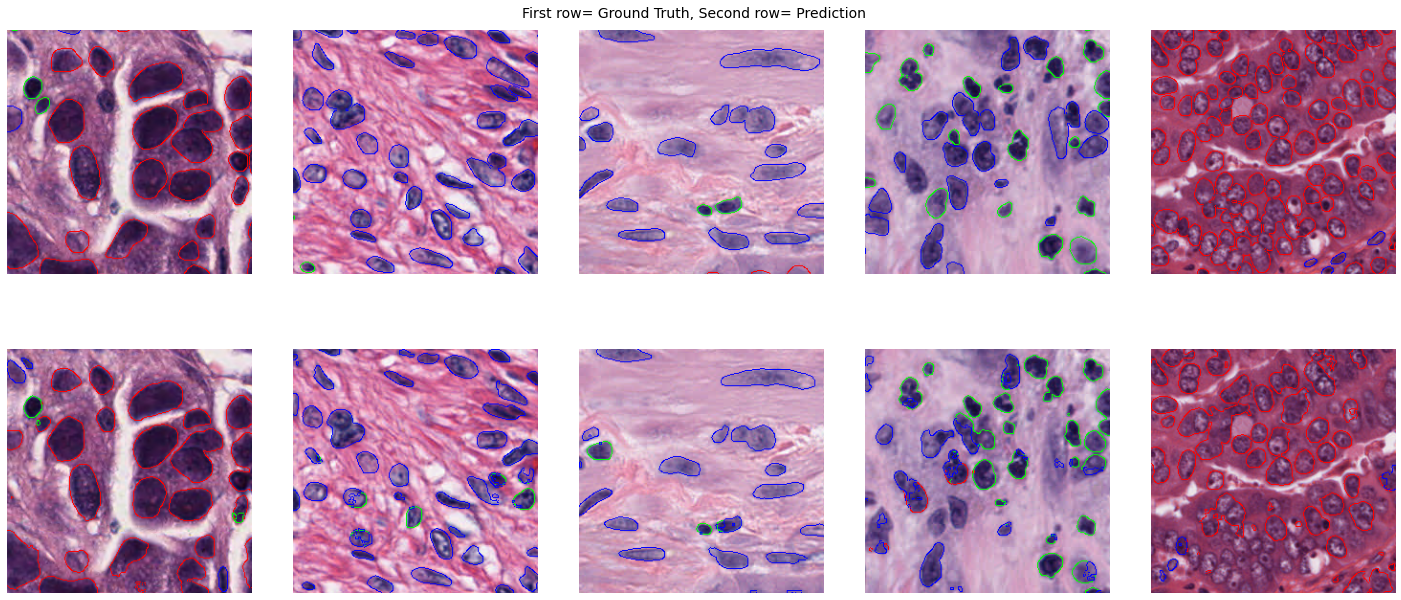




								 SAMPLE: 0


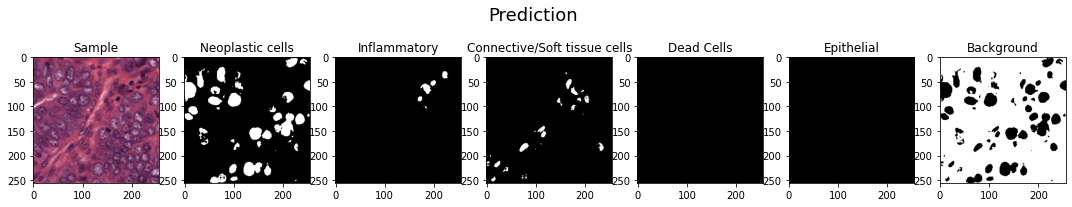

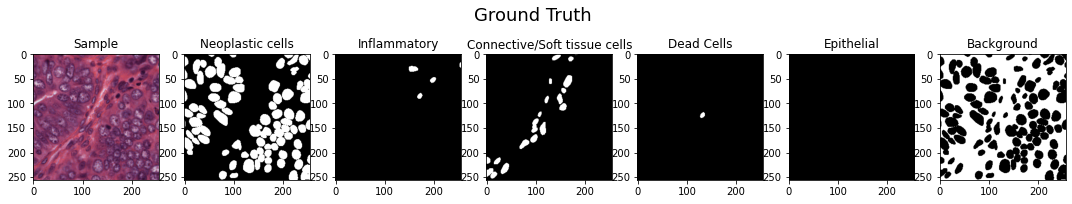




								 SAMPLE: 1


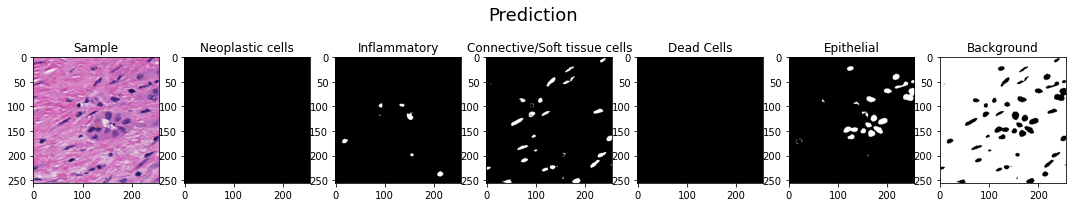

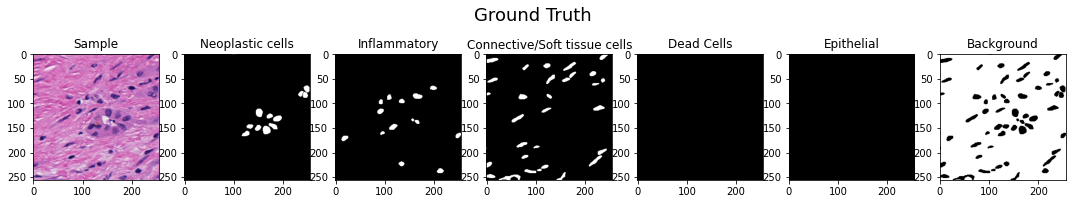




								 SAMPLE: 2


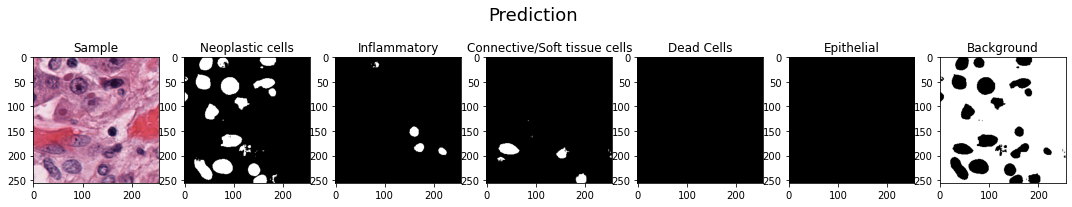

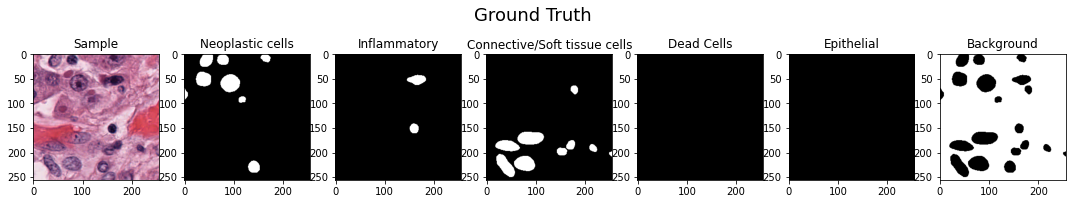




								 SAMPLE: 3


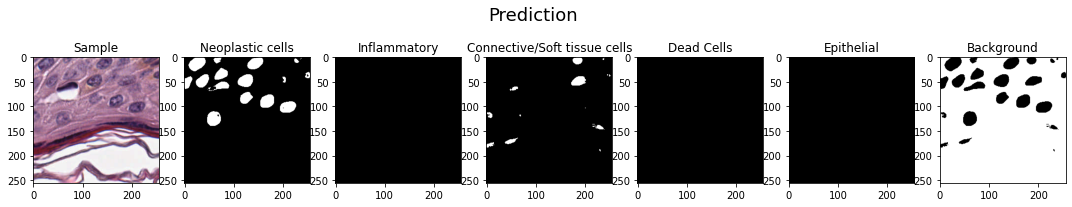

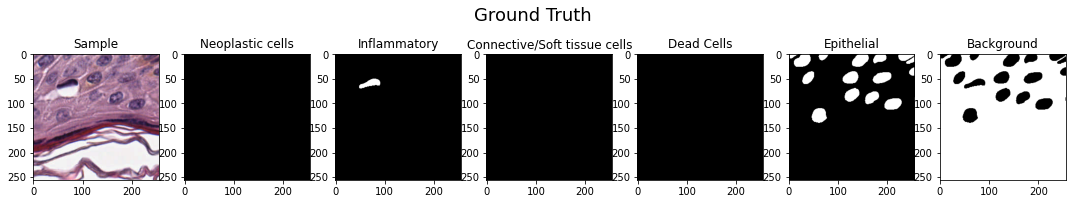




								 SAMPLE: 4


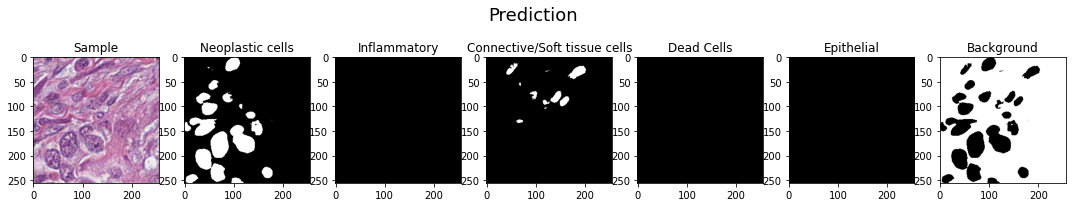

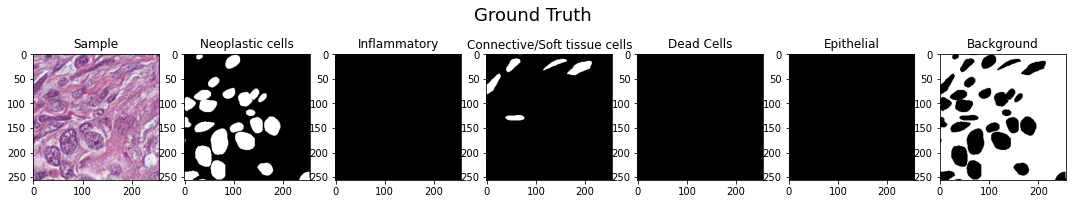

In [ ]:
#test_dir = 'Dataset/test_pickled_data'
test_dir = ROOT_PATH + 'test_pickled_data'
NUM_WORKERS = 4
BATCH_SIZE = 5
test_loader = load_dataset(BATCH_SIZE, shuffle_flag=True, num_workers=NUM_WORKERS, data_dir=test_dir)

# Load best model:
model = MicroNet()
# On Local:
#load_checkpoint(TRAINED_MODEL_PATH+"my.checkpoint_dice+focal.pth.tar", model)
# On Colab:
#load_checkpoint("my_checkpoint_focal_final2.pth.tar", model)
load_checkpoint(ROOT_PATH + "my_checkpoint_focal.pth.tar", model)
model = model.to(device)
    
test_dice_score, test_iou_score = eval_model(model, test_loader, "micronet", device)
# Print statistics:
print("Final DICE score = %f" % (test_dice_score))
print("Final IOU score = %f" % (test_iou_score))

visualize_segmented_ground_truth(test_loader, model, "micronet")
vis_predictions(test_loader, model, "micronet")




